# Distribution for most promising cell types

In [117]:
import sys
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

print(ad.__version__)

# Print the version of the libraries and the Python interpreter
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
# print(f"Matplotlib version: {plt.__version__}")
print(f"Seaborn version: {sns.__version__}")
# print(f"SciPy version: {scipy.__version__}")
print(f"Anndata version: {ad.__version__}")

0.11.4
Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
NumPy version: 1.24.3
Pandas version: 1.5.3
Seaborn version: 0.13.2
Anndata version: 0.11.4


In [ ]:
# Load all the subsets for the following cell types
cell_types = [
    "CD8-positive, alpha-beta T cell",
    "CD8-positive, alpha-beta memory T cell",
    "CD4-positive, alpha-beta T cell",
    "central memory CD4-positive, alpha-beta T cell",
    "effector memory CD4-positive, alpha-beta T cell",
    "gamma-delta T cell",
    "regulatory T cell",
    "double negative T regulatory cell",
    "innate lymphoid cell"
]

# Load the data
adata_cell_types = {}

for cell_type in cell_types:
    file_path = f"../subsets_9/{cell_type}_donors.h5ad"
    adata_cell_types[cell_type] = ad.read_h5ad(file_path)

In [119]:
distribution_cell_types = {}  # Stores donor counts per development stage
distribution_cell_types_cells = {}  # Stores average cells per development stage

for cell_type, adata in adata_cell_types.items():
    print(f"Total number of donors for {cell_type}: {adata.shape}")
    
    # --- Count number of donors per development stage ---
    number_of_donors_per_age = adata.obs['development_stage'].value_counts()
    
    # --- Sum total cells per development stage ---
    number_of_cells_per_age = adata.obs.groupby('development_stage')['n_cells'].sum()

    number_of_donors_per_age = pd.DataFrame(number_of_donors_per_age)
    number_of_cells_per_age = pd.DataFrame(number_of_cells_per_age)
    number_of_donors_per_age.columns = ['number_of_donors']
    number_of_cells_per_age.columns = ['total_number_of_cells']

    # print(number_of_donors_per_age)
    # print(number_of_cells_per_age)

    number_of_donors_per_age.reset_index(inplace=True)
    number_of_cells_per_age.reset_index(inplace=True)

    number_of_donors_per_age.columns = ['development_stage', 'number_of_donors']
    number_of_cells_per_age.columns = ['development_stage', 'total_number_of_cells']

    number_of_donors_per_age['development_stage'] = number_of_donors_per_age['development_stage'].str.extract('(\d+)').astype(int).squeeze()
    number_of_donors_per_age = number_of_donors_per_age.sort_values('development_stage')

    number_of_cells_per_age['development_stage'] = number_of_cells_per_age['development_stage'].str.extract('(\d+)').astype(int).squeeze()
    number_of_cells_per_age = number_of_cells_per_age.sort_values('development_stage')

    
    number_of_donors_per_age.reset_index(inplace=True)
    number_of_cells_per_age.reset_index(inplace=True)

    # number_of_donors_per_age.drop(columns='index', inplace=True)
    # number_of_cells_per_age.drop(columns='index', inplace=True)


    # --- Calculate average cells per donor per stage ---
    average_number_of_cells_per_age = pd.DataFrame({
        'development_stage': number_of_donors_per_age['development_stage'],
        'average_number_of_cells': (
            number_of_cells_per_age['total_number_of_cells'] / 
            number_of_donors_per_age['number_of_donors']
        )
    })
    
    # --- Store results ---
    distribution_cell_types[cell_type] = number_of_donors_per_age
    distribution_cell_types_cells[cell_type] = average_number_of_cells_per_age

Total number of donors for CD8-positive, alpha-beta T cell: (446, 594)
Total number of donors for CD8-positive, alpha-beta memory T cell: (497, 576)
Total number of donors for CD4-positive, alpha-beta T cell: (502, 630)
Total number of donors for central memory CD4-positive, alpha-beta T cell: (501, 646)
Total number of donors for effector memory CD4-positive, alpha-beta T cell: (498, 581)
Total number of donors for gamma-delta T cell: (483, 602)
Total number of donors for regulatory T cell: (500, 603)
Total number of donors for double negative T regulatory cell: (291, 769)
Total number of donors for innate lymphoid cell: (159, 611)


['CD8-positive, alpha-beta T cell', 'CD8-positive, alpha-beta memory T cell', 'CD4-positive, alpha-beta T cell', 'central memory CD4-positive, alpha-beta T cell', 'effector memory CD4-positive, alpha-beta T cell', 'gamma-delta T cell', 'regulatory T cell', 'double negative T regulatory cell', 'innate lymphoid cell']


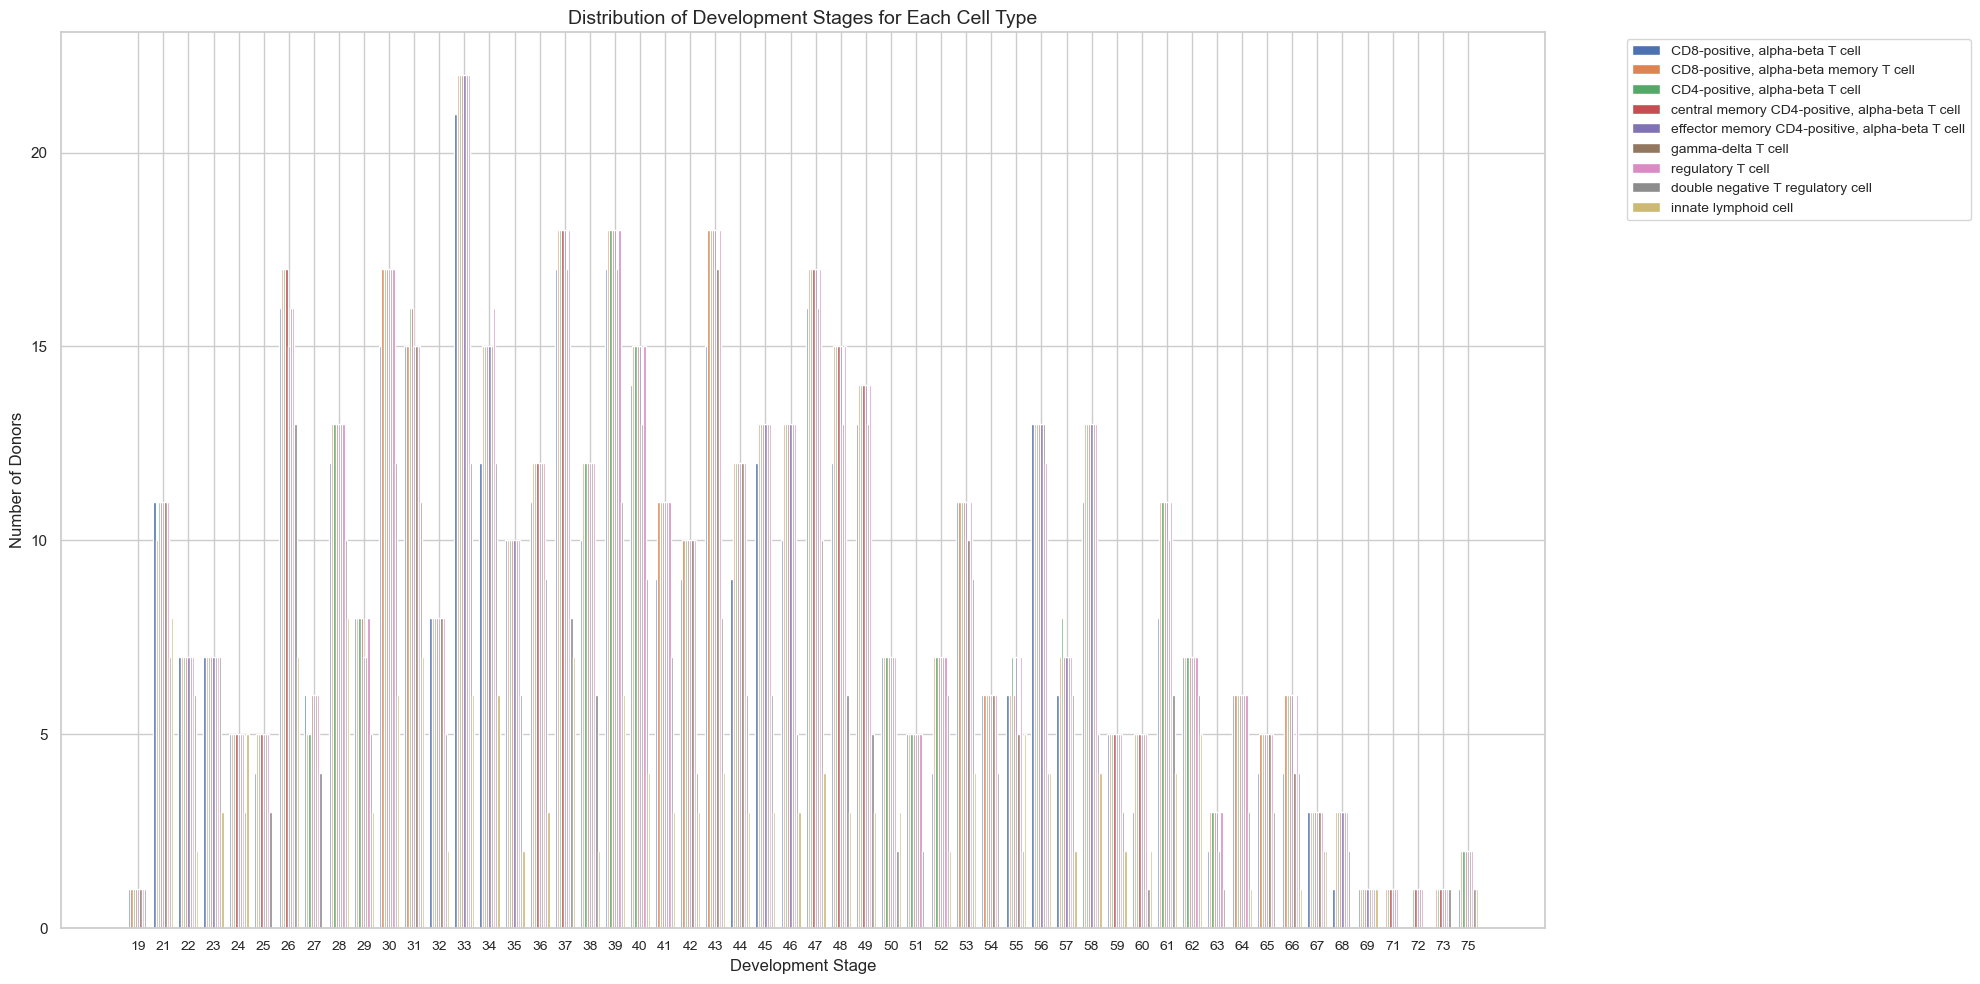

In [120]:
# Get all unique development stages
all_stages = sorted(set().union(*[dist['development_stage'] for dist in distribution_cell_types.values()]))

# Prepare data for plotting
cell_types = list(distribution_cell_types.keys())

print(cell_types)
num_cell_types = len(cell_types)
num_stages = len(all_stages)

# Set up a much larger figure
plt.figure(figsize=(20, 10))

# Set the width of each bar
bar_width = 0.8 / num_cell_types
x = np.arange(num_stages)  # the label locations

# Plot bars for each cell type
for i, (cell_type, distribution) in enumerate(distribution_cell_types.items()):
    stage_to_cells = dict(zip(distribution['development_stage'], distribution['number_of_donors']))
    values = [stage_to_cells.get(stage, 0) for stage in all_stages]
    plt.bar(x + i * bar_width, values, width=bar_width, label=cell_type)

# Add labels and title with adjusted font sizes
plt.xlabel('Development Stage', fontsize=12)  # Slightly smaller than default
plt.ylabel('Number of Donors', fontsize=12)
plt.title('Distribution of Development Stages for Each Cell Type', fontsize=14)

# Adjust x-axis ticks with smaller font
plt.xticks(
    x + bar_width * (num_cell_types - 1) / 2, 
    all_stages,
    fontsize=10
)

# Place legend outside with smaller font
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    fontsize=10
)

plt.tight_layout()
plt.show()

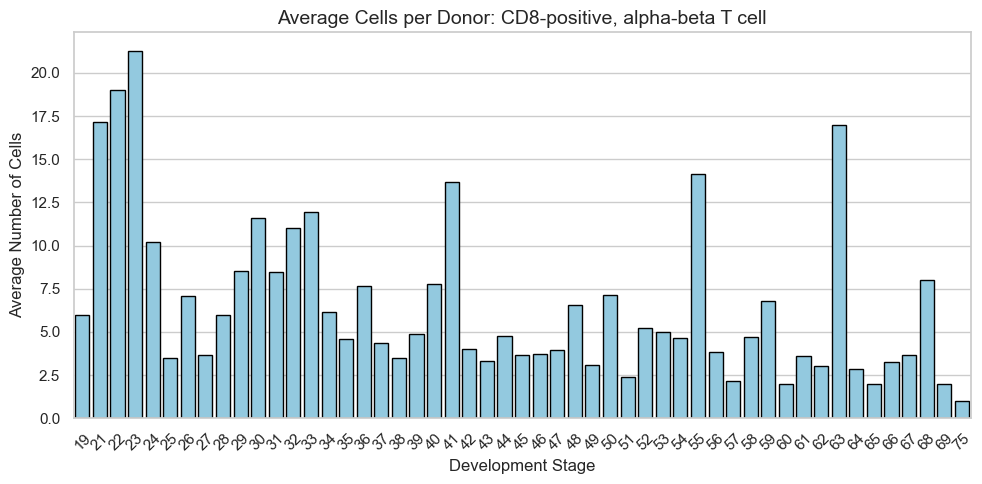

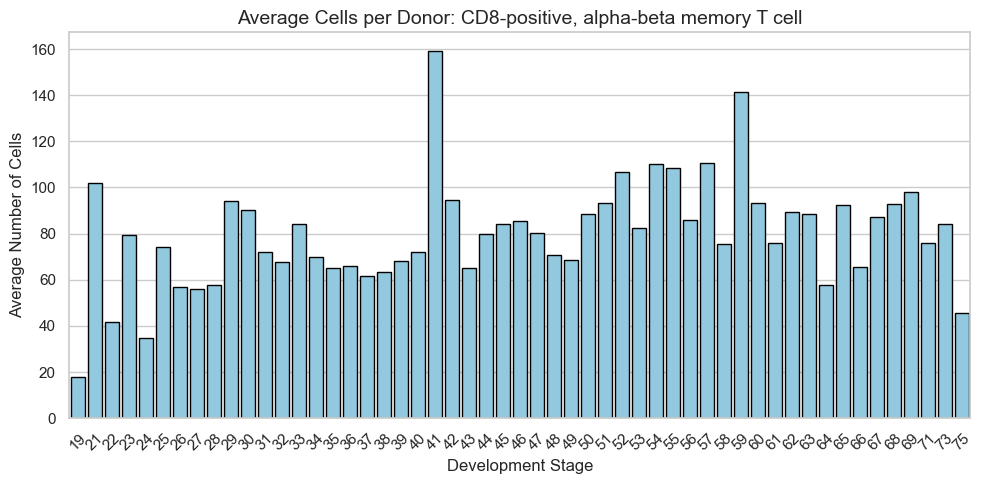

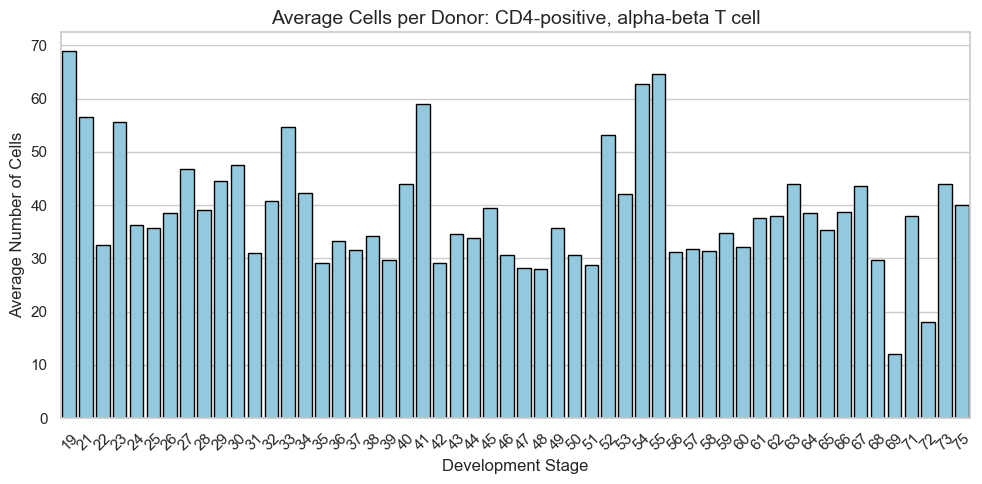

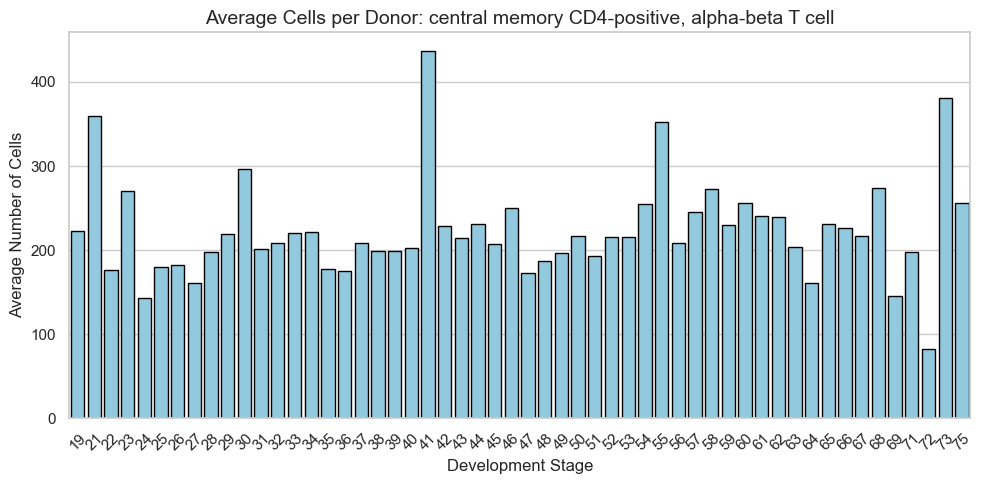

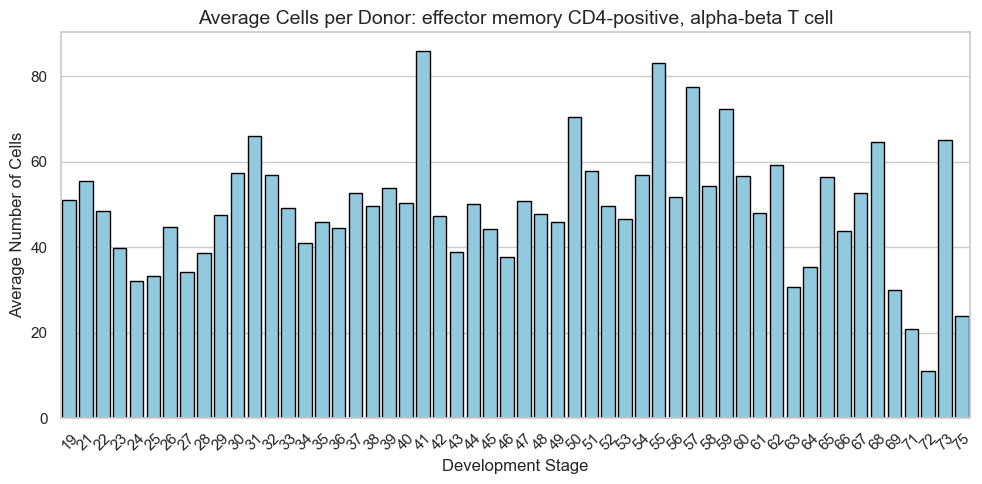

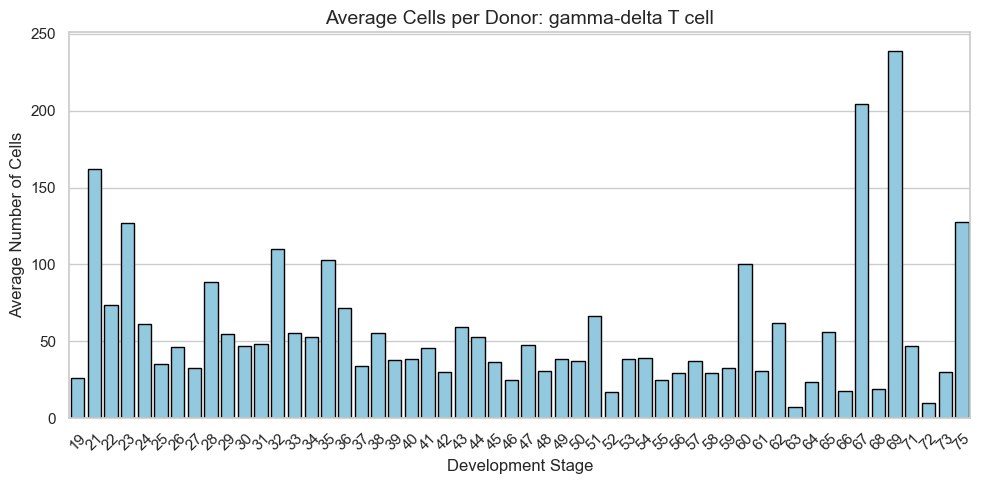

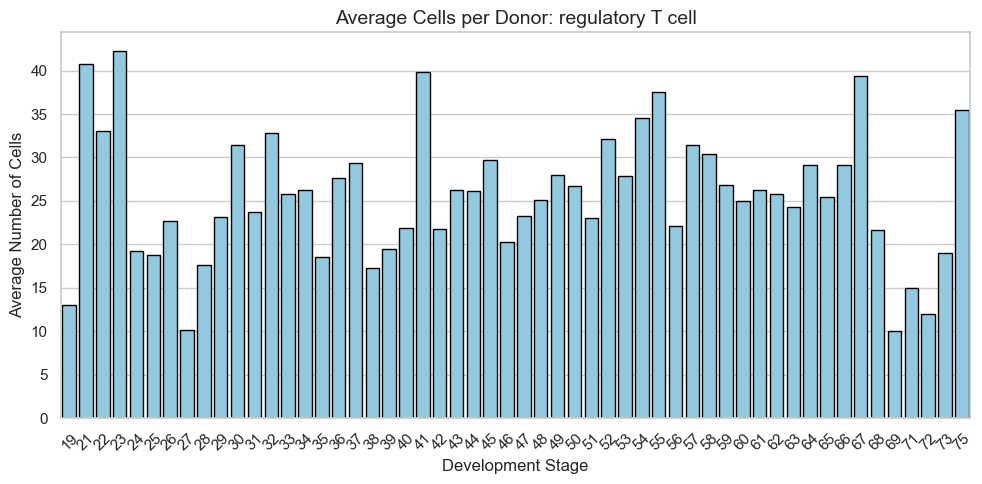

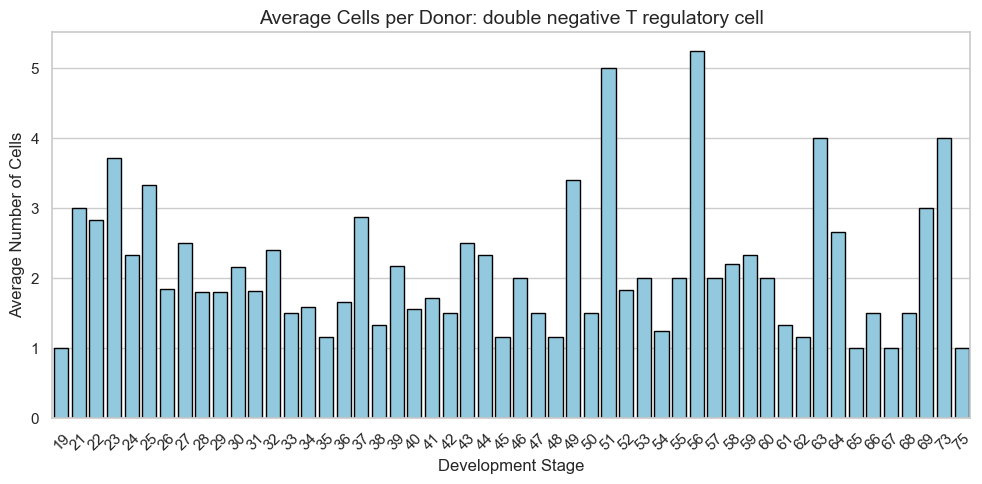

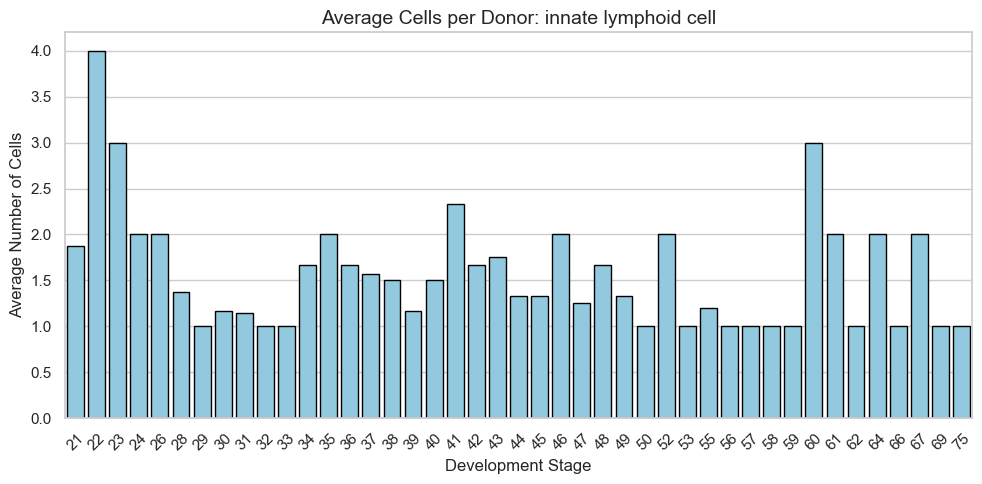

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Loop through each cell type and create a separate plot
for cell_type, df in distribution_cell_types_cells.items():
    plt.figure(figsize=(10, 5))
    
    # Create bar plot
    bar_plot = sns.barplot(
        data=df,
        x='development_stage',
        y='average_number_of_cells',
        color='skyblue',  # Customize color
        edgecolor='black'
    )
    
    # Customize plot
    plt.title(f"Average Cells per Donor: {cell_type}", fontsize=14)
    plt.xlabel("Development Stage", fontsize=12)
    plt.ylabel("Average Number of Cells", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-labels if needed
    plt.tight_layout()  # Prevent label cutoff

    plt.show()

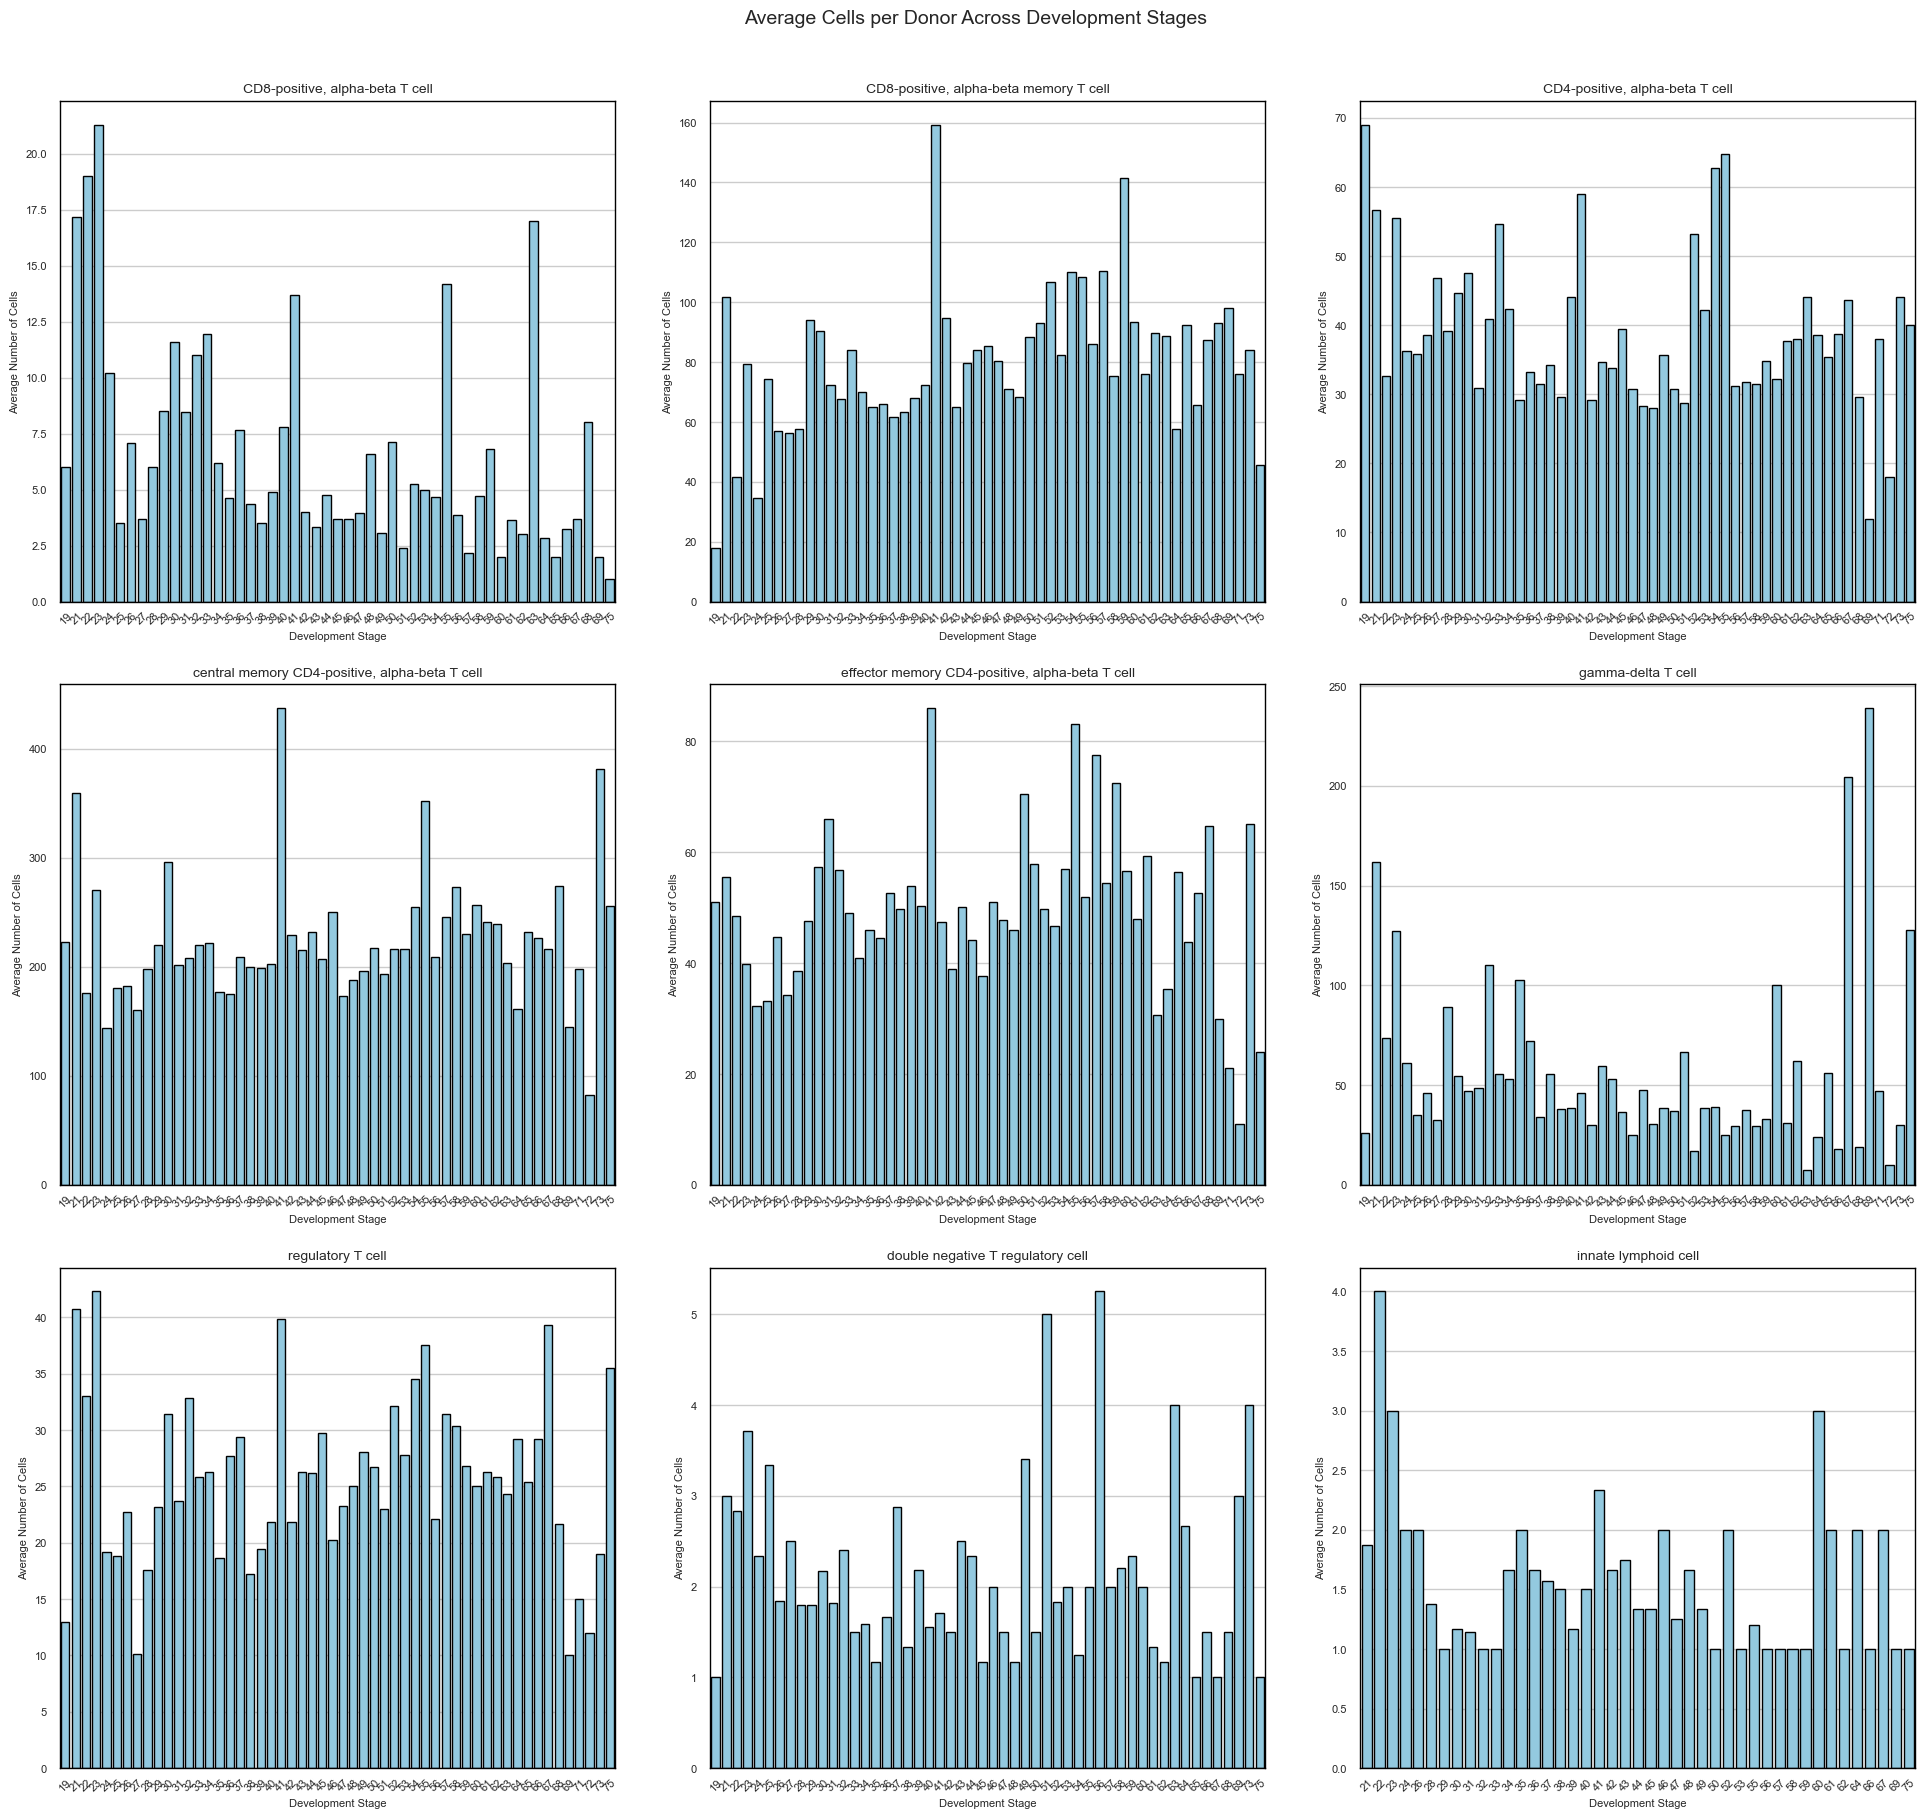

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Set style
sns.set(style="whitegrid")

# Create figure with subplots
n_cols = 3
n_cell_types = len(distribution_cell_types_cells)
n_rows = math.ceil(n_cell_types / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
fig.tight_layout(pad=3.0)  # Reduced padding between subplots

# Flatten axes array
axes = axes.flatten()

# Loop through each cell type
for i, (cell_type, df) in enumerate(distribution_cell_types_cells.items()):
    ax = axes[i]
    
    # Create bar plot
    sns.barplot(
        data=df,
        x='development_stage',
        y='average_number_of_cells',
        color='skyblue',
        edgecolor='black',
        ax=ax
    )
    
    # Customize subplot with smaller labels
    ax.set_title(f"{cell_type}", fontsize=10)  # Smaller title
    ax.set_xlabel("Development Stage", fontsize=8)  # Smaller x-axis label
    ax.set_ylabel("Average Number of Cells", fontsize=8)  # Smaller y-axis label
    
    # Rotate and adjust x-axis ticks
    ax.tick_params(
        axis='x', 
        rotation=45, 
        labelsize=8,  # Smaller x-tick labels
        pad=0.1  # Less padding between ticks and labels
    )
    ax.tick_params(
        axis='y',
        labelsize=8  # Smaller y-tick labels
    )
    
    # Add black border
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Add main title
fig.suptitle('Average Cells per Donor Across Development Stages', 
             fontsize=14, y=1.02)  # Smaller main title

plt.savefig('all_cell_types_average_cells.png', 
            bbox_inches='tight', 
            dpi=300)
plt.show()